In [1]:
import numpy as np

import time
import sys

from matplotlib import pyplot as plt

In [2]:
# Run the Gaussian streaming model!
from LPT.gaussian_streaming_model_fftw import GaussianStreamingModel

# we scale the z = 0 power spectrum given to give z = 0.8 results
z, D, f = 0.8, 0.6819, 0.8076
k, p = np.loadtxt('pk.dat').T

import time
start = time.time()
gsm = GaussianStreamingModel(k, D**2*p, kmin=3e-3, kmax=1, nk=200, one_loop= True, third_order = True,\
                               N = 4000, extrap_min=-6, extrap_max=2, cutoff = 100, threads=1)
gsm.convert_sigma_bases()
end = time.time()
print(end-start)

In function -  __init__
In function -  __init__
In function -  __init__
In function -  __init__
In function -  __init__
In function -  __init__


/Users/sschen/Work/velocileptors/Utils/loginterp.py:16: RuntimeWarning: invalid value encountered in double_scalars
  lneff = derivative(yint, x[l], dx = x[l]*ldx, order = lorder)*x[l]/y[l]
/Users/sschen/Work/velocileptors/Utils/loginterp.py:17: RuntimeWarning: invalid value encountered in double_scalars
  rneff = derivative(yint, x[r], dx = x[r]*rdx, order = rorder)*x[r]/y[r]


In function -  __init__
In function -  __init__
In function -  __init__
In function -  __init__
In function -  __init__
In function -  __init__
In function -  __init__
In function -  __init__
27.271035194396973


In [3]:
# Compute Velocity Statistcs in Configuration Space
# Here the bias parameters are b1, b2, bs, alpha, alpha_v, s2FoG, alpha_s0, alpha_s2
# There are no stochastic contributions in configuration space except for s2FoG
# which corrects for the zero-lag value of the velocity dispersion

bvec = [1,-0.5,0.3,0, 0,0,0,0,0]
gsm.compute_cumulants(*bvec)

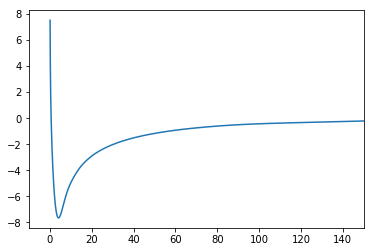

In [4]:
# For example we can plot the dipole of the mean pairwise velocity:
plt.plot(gsm.rint, gsm.veft)

plt.xlim(-10,150)

#plt.ylim(0,100)

plt.show()

In [5]:
# Now integrate to get the correlation function multipoles:

rs = np.linspace(5,135,61)
xi0s = np.zeros_like(rs)
xi2s = np.zeros_like(rs)

start = time.time()
for ii, rr in enumerate(rs):
    xi0, xi2, xi4 = gsm.compute_xi_ell(rr, f, *bvec, rwidth=50)
    xi0s[ii] = xi0
    xi2s[ii] = xi2
end = time.time()
print(end-start)


0.3040578365325928


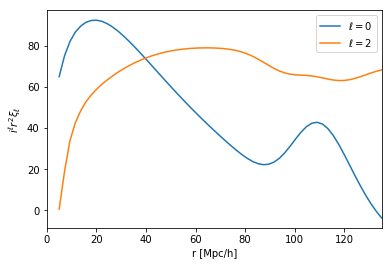

In [6]:
plt.plot(rs, rs**2 * xi0s, label=r'$\ell = 0$')
plt.plot(rs, -rs**2 * xi2s, label=r'$\ell = 2$')


plt.xlim(0,135)

plt.legend()
plt.xlabel('r [Mpc/h]')
plt.ylabel(r'$ i^\ell r^2 \xi_\ell$')

plt.show()